In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [10]:
#get column information (station)
first_row_station = session.query(station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x117fe2150>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'longitude': -157.8168}

In [11]:
#get column info (measurement)
first_row_measure = session.query(measurement).first()
first_row_measure.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x118015b10>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(last_date)

# 1 year before last date is query_date 
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=366)
print("Query Date: ", query_date)

# Perform a query to retrieve the data and precipitation scores
twelvemonth = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date > query_date).\
    order_by(measurement.date).statement

('2017-08-23',)
Query Date:  2016-08-22


In [24]:
# Save the query results as a Pandas DataFrame and 
conn=engine.connect()
df = pd.read_sql_query(twelvemonth, conn)
df = df.rename(columns={'date':'Date',
                  'prcp':'Precipitation'})

In [28]:
# Sort the dataframe by date
date_df = df.sort_values('Date')
date_df = date_df.dropna()
date_df.head()

,Precipitation,Date
0,0.00,2016-08-23
1,0.15,2016-08-23
2,0.05,2016-08-23
4,0.02,2016-08-23
5,1.79,2016-08-23


In [29]:
# Set the index to the date column
date_df=date_df.set_index('Date')
date_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


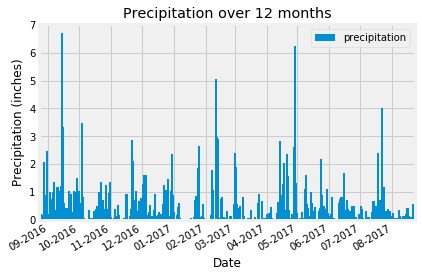

In [31]:
# Define axis, x-axis is object; converted to datetime format
x_axis = [datetime.strptime(r.Index,'%Y-%m-%d').date() for r in date_df.itertuples(index=True)]
y_axis = date_df.Precipitation

# plot bar graph with defined x- and y-axis
fig, ax = plt.subplots()
ax.bar(x_axis, y_axis, width=2, label= 'precipitation')
ax.set_title('Precipitation over 12 months')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_xlim(min(x_axis),max(x_axis))
ax.legend(loc='upper right')

#use the DateFormatter to format x-axis with monthly x-ticks
import matplotlib.dates as mdates
months = mdates.MonthLocator()         #every month
myFmt = mdates.DateFormatter('%m-%Y')  #format ticker to read 'month-year'

ax.xaxis.set_major_locator(months)     #major locator will plot ticks monthly
ax.xaxis.set_major_formatter(myFmt)    #major formatter plots date format

fig.autofmt_xdate()                    #autoformat date to fit axis
fig.savefig('Precipitation.png')

In [32]:
#Summary statistics
date_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?
station_count=session.query(station.id).count()
print(f'There are {station_count} weather stations.')

There are 9 weather stations.


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(measurement.station, station.name, func.count(measurement.id)).\
    filter(measurement.station == station.station).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_station

print(f'The most active station (count = {active_station[0][2]}) id is {active_station[0][0]}.')
print(f'The least active station (count = {active_station[-1][2]}) id is {active_station[-1][0]}.')

The most active station (count = 2772) id is USC00519281.
The least active station (count = 511) id is USC00518838.


In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

from statistics import mean 

most_active_station_temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).count()

most_temps = session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281', measurement.station == station.station).all()

# most_active_station_temps is a list of tuples. unpack into list of integers
temperatures = [temp[0] for temp in most_temps]                

low_temp=min(temperatures)
high_temp=max(temperatures)
avg_temp=mean(temperatures)

print(f'{active_station[0][0]} has a total of {most_active_station_temps} temperature observations')
print(f' The lowest temp recorded is {low_temp}, the highest temp recorded is {high_temp}, and the average temp is {round(avg_temp,2)} from the most active station ({active_station[0][0]}).')


USC00519281 has a total of 2772 temperature observations
 The lowest temp recorded is 54.0, the highest temp recorded is 85.0, and the average temp is 71.66 from the most active station (USC00519281).
